# Sentiment Analysis using BiLSTM
________________________________________________________________________________________

Code consists of  :
1. import modules
2. data preprocessing
3. tokenization
4. word2vec model
5. embedding layer
6. building BiLSTM model
7. model evaluation
8. sentiment prediction

# 1. Import Modules

In [24]:
import pandas as pd
import nltk
import time
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# data preprocessing
import string
import emoji
import re
import nltk
from textblob import TextBlob
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize

# model training
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from tensorflow.keras import utils
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Word2vec
import gensim

# save model
import pickle

In [25]:
data = pd.read_csv('IMDB_Dataset_label.csv')

In [26]:
data.head(5)

,Unnamed: 0,review,sentiment,label
0,0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fact that it goes where other shows wouldn't dare. Forget pretty pictures painted for mainstream audiences, forget charm, forget romance...OZ doesn't mess around. The first episode I ever saw struck me as so nasty it was surreal, I couldn't say I was ready for it, but as I watched more, I developed a taste for Oz, and got accustomed to the high levels of graphic violence. Not just violence, but injustice (crooked guards who'll be sold out for a nickel, inmates who'll kill on order and get away with it, well mannered, middle class inmates being turned into prison bitches due to their lack of street skills or prison experience) Watching Oz, you may become comfortable with what is uncomfortable viewing....thats if you can get in touch with your darker side.",positive,1
1,1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only ""has got all the polari"" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell's murals decorating every surface) are terribly well done.",positive,1
2,2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I'd laughed at one of Woody's comedies in years (dare I say a decade?). While I've never been impressed with Scarlet Johanson, in this she managed to tone down her ""sexy"" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than ""Devil Wears Prada"" and more interesting than ""Superman"" a great comedy to go see with friends.",positive,1
3,3,"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides t

The dataset has 4 columns 'unnamed', 'review', 'sentiment', 'label'
the unnamed column does not give any information and can be disregarded

In [27]:
# check the number of postive and negative reviews
data.sentiment.value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

C:\Users\jingy\AppData\Local\Temp\ipykernel_20428\1302402582.py:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_Class = pd.value_counts(data.label, sort=True)


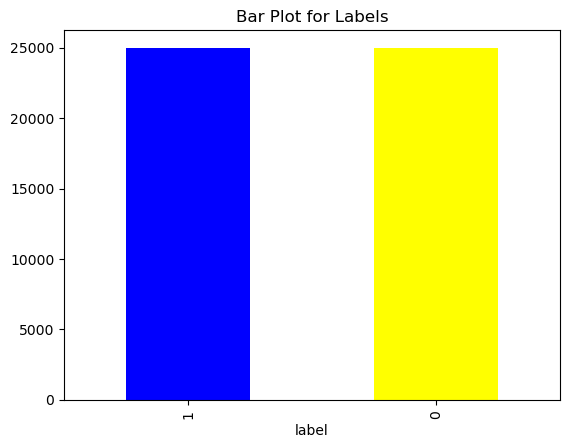

In [28]:
# visualise the distribution of labels in the dataset in bar plots
count_Class = pd.value_counts(data.label, sort=True)
count_Class.plot(kind = 'bar', color = ['blue', 'yellow'])
plt.title("Bar Plot for Labels")
plt.show()

# 2. Data Preprocessing

The purpose of data preprocessing is to prepare data for building BiLSTM models. Data preprocessing improves accuracy and reliability of models by removing inconsistent or missing data.

### Text Preprocessing
remove noises in the data, numbers, hashtags, punctuations, lowercase all characters, demoji, remove stopwords and lemmatize texts

In [29]:
# spacy for lemmatization
import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
# nltk for removing stop words
stopwords = nltk.corpus.stopwords.words('english')

def preprocess(text):
    #1. Generating the list of words in the tweet (hastags and other punctuations removed)
    text_blob = TextBlob(text)
    text = ' '.join(text_blob.words)
    #2. clean the number 
    text = re.sub(r'[0-9]', '', text)
    #3. lower the text
    text = text.lower()
    #4. conver the emoji to text form
    text = emoji.demojize(text)
    #5. remove punctuation 
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    #6. tokenize the text
    text = word_tokenize(text)
    #7. remove empty token
    text = [t for t in text if len(t) > 0]
    #8. remove non-alphabetical token
    text = [t for t in text if t.isalpha()]
    #9. replace the negation token
    replacer  = AntonymReplacer()
    text = replacer.replace_negations(text)
    #10. remove the stopwords
    text = [i for i in text if i not in stopwords]
    #11. lemmatize the text
    text = lemmatization(text, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    return " ".join(text)


def lemmatization(sent, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    doc = nlp(" ".join(sent)) 
    texts_out = [token.lemma_ for token in doc if token.pos_ in allowed_postags]
    return texts_out

class AntonymReplacer(object):
    def replace(self, word, pos=None):
        antonyms = set()

        for syn in wordnet.synsets(word, pos=pos):
            for lemma in syn.lemmas():
                for antonym in lemma.antonyms():
                    antonyms.add(antonym.name())

        if len(antonyms) == 1:
            return antonyms.pop()
        else:
            return None

    def replace_negations(self, sent):
        i, l = 0, len(sent)
        words = []

        while i < l:
            word = sent[i]

            if word == 'not' and i+1 < l:
                ant = self.replace(sent[i+1])

                if ant:
                    words.append(ant)
                    i += 2
                    continue

            words.append(word)
            i += 1

        return words

In [30]:
%%time
# preprocess data
data['clean'] = data['review'].apply(lambda rev : preprocess(rev))

CPU times: total: 7min 10s
Wall time: 7min 12s


### 2.2 Check Processed Data

In [31]:
pd.set_option("max_colwidth", None)
data.review[1]

'A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master\'s of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell\'s murals decorating every surface) are terribly well d

In [32]:
# data after preprocessing
data.clean[1]

'wonderful little production br br film technique unassume oldtimebbc fashion give comforting sometimes discomforte sense realism entire piece actor extremely well choose get polari voice pat truly see seamless editing guide reference diary entry well worth watch terrificly write perform piece masterful production great master comedy life br really come home little thing fantasy guard rather use traditional dream technique remain solid disappear play knowledge sense particularly scene concern set particularly flat halliwell mural decorate surface terribly well do'

We can see that, after text preprocessing, the number of words have been reduced, punctuations are removed, and all words are lowercased.

### 2.3 Split dataset into training and testing dataset

In [33]:
# split data into train and test set
X = data['review'].values
y = data['sentiment'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# 3. Tokenization 

In [34]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['clean'])

In [35]:
sequences = tokenizer.texts_to_sequences(data.clean)
print("After converting our words in the corpus into vector of integers:\n")
print("Vector of words of the first review :")
print(sequences[0])

After converting our words in the corpus into vector of integers:

Vector of words of the first review :
[951, 299, 11, 148, 1512, 98, 429, 81, 31, 32, 851, 3562, 9370, 18, 408, 82, 98, 219, 9, 1256, 17, 4141, 3917, 9550, 17, 460, 1395, 848, 526, 252, 408, 2865, 189, 53, 219, 127, 5822, 27, 14986, 4603, 1876, 537, 33677, 482, 1019, 1540, 873, 1527, 1482, 713, 173, 16950, 10365, 163, 3321, 465, 226, 39, 11704, 754, 1895, 15610, 180, 1644, 5934, 6259, 5633, 5380, 40, 114, 208, 21, 157, 644, 17, 477, 80, 9, 17, 1270, 319, 79, 213, 1036, 1815, 136, 319, 896, 319, 587, 4698, 579, 31, 148, 49, 3, 851, 1129, 1585, 21, 1210, 11, 534, 795, 6, 11392, 163, 375, 1040, 408, 408, 4264, 3342, 1703, 727, 16222, 3604, 88, 372, 6, 8, 7320, 695, 513, 3604, 75, 873, 3400, 477, 222, 656, 959, 873, 284, 11, 4698, 71, 2580, 2250, 2054, 6, 389, 364, 301]


In [36]:
vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 89902


In [37]:
encoded_X_train = tokenizer.texts_to_sequences(X_train)
encoded_X_test = tokenizer.texts_to_sequences(X_test)

In [38]:
# when maxlen is set to 300, sentences which are shorter than length 300 will have 0 values added to it, 
# so every sentences will have length of 300
# maximum sentence length is capped at 300, if exceeded sentence will be pruned to length 300
SEQUENCE_LENGTH = 300
padded_X_train = pad_sequences(encoded_X_train, maxlen=SEQUENCE_LENGTH)
padded_X_test = pad_sequences(encoded_X_test, maxlen=SEQUENCE_LENGTH)

padded_X_train

array([[    0,     0,     0, ...,  7812, 38863,    48],
       [    0,     0,     0, ...,  1282, 21518,    11],
       [    0,     0,     0, ..., 23304, 14162,    14],
       ...,
       [    0,     0,     0, ...,   831, 23304,  4414],
       [    0,     0,     0, ...,   169,    11,  9620],
       [    0,     0,     0, ...,   286,    22,  7611]])

In [39]:
# shape of training data,  number of column will be 300 as every review will have length of 300
padded_X_train.shape

(40000, 300)

In [40]:
# save tokenizer to be used later on
tokenizer_file = 'tokenizer.sav'
pickle.dump(tokenizer, open(tokenizer_file, 'wb'))

In [41]:
# add neutral into the labels
labels = data.sentiment.unique().tolist()
labels.append("neutral")
labels

['positive', 'negative', 'neutral']

In [42]:
# change positive and negative into 1 and 0
encoder = LabelEncoder()
encoder.fit(data.sentiment.tolist())

y_train = encoder.transform(y_train.tolist()) 
y_test = encoder.transform(y_test.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [43]:
print("x_train", padded_X_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", padded_X_test.shape)
print("y_test", y_test.shape)

x_train (40000, 300)
y_train (40000, 1)

x_test (10000, 300)
y_test (10000, 1)


# Part 1

# 4. Word2Vec model 1 (CBOW)

In [56]:
# params for word2vec model
# w2v size must be same as number of columns of dataset
W2V_SIZE = 300
BATCH_SIZE = 1024

In [45]:
# check the number of reviews
documents = [_text.split() for _text in data.review]

print(f"There are a total of {len(documents)}")

There are a total of 50000


In [41]:
%%time
# Create CBOW model
# for CBOW, will he using sg=0
model1 = gensim.models.Word2Vec(documents, min_count = 10, vector_size = W2V_SIZE, window = 5, sg=0, hs = 1, negative=0)

Wall time: 1min 11s


In [42]:
# Print some cosine similarity results of tokens in the vocabulary
print("Cosine similarity between 'violence' " + "and 'drug' - CBOW : ", model1.wv.similarity('violence', 'drugs'))

print("\nCosine similarity between 'drugs' " + "and 'alcohol' - CBOW : ", model1.wv.similarity('drug', 'alcohol'))

print("\nCosine similarity between 'violence' " + "and 'kindness' - CBOW : ", model1.wv.similarity('violence', 'kindness'))

Cosine similarity between 'violence' and 'drug' - CBOW :  0.29171097

Cosine similarity between 'drugs' and 'alcohol' - CBOW :  0.35892326

Cosine similarity between 'violence' and 'kindness' - CBOW :  0.19055548


In [43]:
#Get most similar words with 'drugs' - CBOW
similar_words1 = model1.wv.most_similar('drugs')
print(similar_words1)

[('drugs,', 0.6361526250839233), ('alcohol', 0.4694453775882721), ('prostitutes', 0.4278550446033478), ('hippies', 0.4248656630516052), ('drug', 0.42100954055786133), ('animals', 0.4000183045864105), ('prostitution', 0.3882197439670563), ('humans', 0.38740891218185425), ('convicts', 0.3863775134086609), ('abuse', 0.38533318042755127)]


# 5. Embedding Layer

Embedding layer is 

In [44]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
    if word in model1.wv:
        embedding_matrix[i] = model1.wv[word]
print(embedding_matrix.shape)

(89902, 300)


In [45]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

# 6. Building BiLSTM Model using CBOW

In [46]:
cbow_model = Sequential()
cbow_model.add(embedding_layer)
cbow_model.add(Bidirectional(LSTM(100)))
cbow_model.add(Dropout(0.5))
cbow_model.add(Dense(1, activation='sigmoid'))
# compile BiLSTM model
cbow_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 

# summarize the model
print(cbow_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          26970600  
                                                                 
 bidirectional (Bidirectiona  (None, 200)              320800    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 27,291,601
Trainable params: 321,001
Non-trainable params: 26,970,600
_________________________________________________________________
None


In [47]:
# check the input and output dimension of each layer
for l in cbow_model.layers:
    print("layer : ", l.name, ", expects input  of shape : ",l.input_shape)

layer :  embedding , expects input  of shape :  (None, 300)
layer :  bidirectional , expects input  of shape :  (None, 300, 300)
layer :  dropout , expects input  of shape :  (None, 200)
layer :  dense , expects input  of shape :  (None, 200)


### 6.1 Train  Model

In [58]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)] #change 'val_acc' to 'val_accuracy'

In [49]:
EPOCHS = 32
BATCH_SIZE = 1024

# fit the model
history = cbow_model.fit(x=padded_X_train,
                         y=y_train,
                         batch_size=16,
                         epochs=10,
                         validation_data=(padded_X_test, y_test), 
                         verbose=1,
                         callbacks=callbacks
                         )

Epoch 1/32
2500/2500 [==============================] - 335s 133ms/step - loss: 0.4307 - accuracy: 0.8111 - val_loss: 0.3191 - val_accuracy: 0.8651 - lr: 0.0010
Epoch 2/32
2500/2500 [==============================] - 223s 89ms/step - loss: 0.2929 - accuracy: 0.8806 - val_loss: 0.2670 - val_accuracy: 0.8878 - lr: 0.0010
Epoch 3/32
2500/2500 [==============================] - 203s 81ms/step - loss: 0.2592 - accuracy: 0.8964 - val_loss: 0.2632 - val_accuracy: 0.8935 - lr: 0.0010
Epoch 4/32
2500/2500 [==============================] - 207s 83ms/step - loss: 0.2274 - accuracy: 0.9115 - val_loss: 0.2568 - val_accuracy: 0.8939 - lr: 0.0010
Epoch 5/32
2500/2500 [==============================] - 213s 85ms/step - loss: 0.1963 - accuracy: 0.9257 - val_loss: 0.2890 - val_accuracy: 0.8875 - lr: 0.0010
Epoch 6/32
2500/2500 [==============================] - 217s 87ms/step - loss: 0.1671 - accuracy: 0.9365 - val_loss: 0.2692 - val_accuracy: 0.8934 - lr: 0.0010
Epoch 7/32
2500/2500 [=================

In [99]:
#save model
cbow_model.save('CBOW_BiLSTM.sav')
model1.save('CBOW_model')
pickle.dump(tokenizer, open('BiLSTM_tokenizer.pkl', "wb"), protocol=0)
pickle.dump(encoder, open('encoder.pkl', "wb"), protocol=0)

INFO:tensorflow:Assets written to: CBOW_BiLSTM.sav\assets


INFO:tensorflow:Assets written to: CBOW_BiLSTM.sav\assets


# 7. Model Evaluation

To evaluate BiLSTM model, we will be using classification report which shows the accuracy, confusion matrix and accuracy and loss graph

In [66]:
def c_report(y_true, y_pred):
    print("Classification Report")
    print(classification_report(y_true, y_pred))


def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.5, cmap="Blues", cbar=False)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [51]:
cbow_preds = (cbow_model.predict(padded_X_test) > 0.5)

In [52]:
c_report(y_test, cbow_preds)

Classification Report
              precision    recall  f1-score   support

           0       0.88      0.90      0.89      4961
           1       0.90      0.88      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



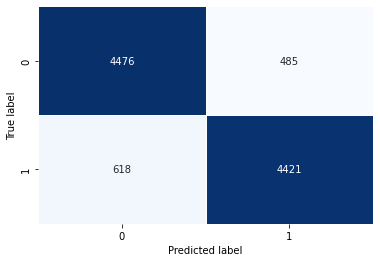

In [53]:
plot_confusion_matrix(y_test, cbow_preds)

Number of correctly predicted sentiments is 4476 + 4421, and the total number of sentiments predicted is 10000.

The accuracy is number of correctly predicted sentiments / total number of sentiments predicted,
8897/10000 = 0.8897

In [54]:
%%time
cbow_score = cbow_model.evaluate(padded_X_test, y_test, batch_size=16)
print("\n", cbow_score)
print("ACCURACY:",cbow_score[1])
print("LOSS:",cbow_score[0])

625/625 [==============================] - 22s 36ms/step - loss: 0.3502 - accuracy: 0.8897

 [0.350180059671402, 0.8896999955177307]
ACCURACY: 0.8896999955177307
LOSS: 0.350180059671402
Wall time: 22.3 s


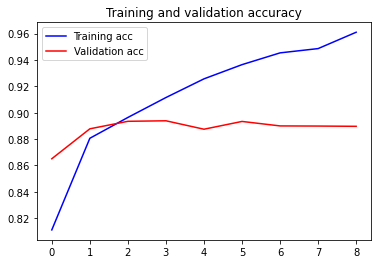

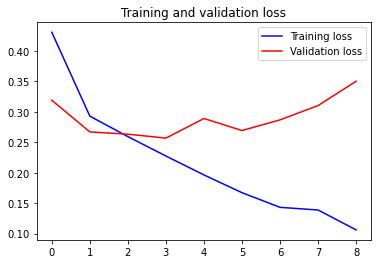

In [55]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

The training accuracy increased for the first few epochs and suddenly dropped a little then increase for a little and become constant. we can see that the validation accuracy does not increase exponentially like the training accuracy.
The same goes for training and validation loss. 

# 8. Sentiment Prediction using CBOW

In [70]:
# SENTIMENT
POSITIVE = "positive"
NEGATIVE = "negative"
NEUTRAL = "neutral"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

In [71]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [90]:
def cbow_predict(text, include_neutral=True):
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = cbow_model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"The sentence is ": label, "score": float(score)}

In [91]:
cbow_predict("I think this is a very great movie.")

C:\Users\jingy\AppData\Local\Temp/ipykernel_1448/1279217327.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return {"The sentence is ": label, "score": float(score)}


{'The sentence is ': 'positive', 'score': 0.9383248090744019}

In [92]:
cbow_predict("The movie is so bad, the actors are even worse.")

C:\Users\jingy\AppData\Local\Temp/ipykernel_1448/1279217327.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return {"The sentence is ": label, "score": float(score)}


{'The sentence is ': 'negative', 'score': 0.00794142484664917}

# Part 2

Part 1 to 3 will be same as CBOW model

# 4. Skipgram Model

In [48]:
# Create Skip Gram model
model2 = gensim.models.Word2Vec(documents, min_count = 5, vector_size = W2V_SIZE, window = 5, sg = 1, hs = 1, negative=0)

In [49]:
#Vocab in the models
wv_vocab_size2 = len(model2.wv)
print(f"Number of vocab in Skipgram Model:{wv_vocab_size2}")

Number of vocab in Skipgram Model:76833


In [51]:
# Print some cosine similarity results of tokens in the vocabulary
print("Cosine similarity between 'violence' " + "and 'drug' - Skipgram : ", model2.wv.similarity('violence', 'drugs'))

print("\nCosine similarity between 'drugs' " + "and 'alcohol' - Skipgram : ", model2.wv.similarity('drug', 'alcohol'))

print("\nCosine similarity between 'violence' " + "and 'kindness' - Skipgram : ", model2.wv.similarity('violence', 'kindness'))

Cosine similarity between 'violence' and 'drug' - Skipgram :  0.34947568

Cosine similarity between 'drugs' and 'alcohol' - Skipgram :  0.5067208

Cosine similarity between 'violence' and 'kindness' - Skipgram :  0.24092786


# 5. Embedding layer

In [52]:
embedding_matrix2 = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
    if word in model2.wv:
        embedding_matrix2[i] = model2.wv[word]
print(embedding_matrix2.shape)

(89902, 300)


In [53]:
embedding_layer2 = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix2], input_length=SEQUENCE_LENGTH, trainable=False)

# 6. Building BiLSTM Model using Skipgram

In [54]:
sg_model = Sequential()
sg_model.add(embedding_layer2)
sg_model.add(Bidirectional(LSTM(100)))
sg_model.add(Dropout(0.5))
sg_model.add(Dense(1, activation='sigmoid'))

sg_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 

# summarize the model
print(sg_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          26970600  
                                                                 
 bidirectional (Bidirectiona  (None, 200)              320800    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 27,291,601
Trainable params: 321,001
Non-trainable params: 26,970,600
_________________________________________________________________
None


### 6.2 Train Model

In [61]:
# fit the model
history2 = sg_model.fit(x=padded_X_train,
                        y=y_train,
                        batch_size=16,
                        epochs=10,
                        validation_data=(padded_X_test, y_test), 
                        verbose=1,
                        callbacks=callbacks
                        )

Epoch 1/10
2500/2500 [==============================] - 277s 110ms/step - loss: 0.3793 - accuracy: 0.8371 - val_loss: 0.3491 - val_accuracy: 0.8417 - lr: 0.0010
Epoch 2/10
2500/2500 [==============================] - 264s 105ms/step - loss: 0.2930 - accuracy: 0.8805 - val_loss: 0.2638 - val_accuracy: 0.8883 - lr: 0.0010
Epoch 3/10
2500/2500 [==============================] - 270s 108ms/step - loss: 0.2584 - accuracy: 0.8968 - val_loss: 0.2467 - val_accuracy: 0.8996 - lr: 0.0010
Epoch 4/10
2500/2500 [==============================] - 276s 110ms/step - loss: 0.2368 - accuracy: 0.9075 - val_loss: 0.2565 - val_accuracy: 0.9000 - lr: 0.0010
Epoch 5/10
2500/2500 [==============================] - 281s 113ms/step - loss: 0.2134 - accuracy: 0.9155 - val_loss: 0.2452 - val_accuracy: 0.8977 - lr: 0.0010
Epoch 6/10
2500/2500 [==============================] - 285s 114ms/step - loss: 0.1920 - accuracy: 0.9251 - val_loss: 0.2478 - val_accuracy: 0.9015 - lr: 0.0010
Epoch 7/10
2500/2500 [============

In [63]:
#save model
sg_model.save('sg_BiLSTM.sav')
model2.save('sg_model')

INFO:tensorflow:Assets written to: sg_BiLSTM.sav\assets


INFO:tensorflow:Assets written to: sg_BiLSTM.sav\assets


# 7. Model Evaluation

The model is evaluated using 4 methods:
1. Classification Report
2. Confusion Matrix
3. Accuracy
4. training and validation accuracy and loss graphs

In [64]:
sg_preds = (sg_model.predict(padded_X_test) > 0.5)

In [67]:
c_report(y_test, sg_preds)

Classification Report
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      4961
           1       0.89      0.91      0.90      5039

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



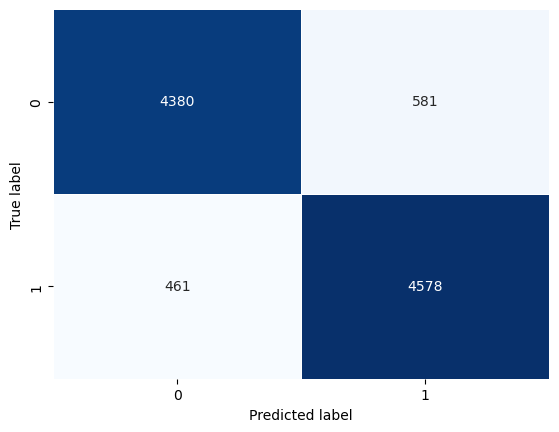

In [68]:
plot_confusion_matrix(y_test, sg_preds)

Number of correctly predicted sentiments is 4380 + 4578, and the total number of sentiments predicted is 10000.

The accuracy is number of correctly predicted sentiments / total number of sentiments predicted,
8957/10000 = 0.8957

In [69]:
%%time
# outputs the accuracy and the loss
sg_score = sg_model.evaluate(padded_X_test, y_test, batch_size=16)
print("\n", sg_score)
print("ACCURACY:",sg_score[1])
print("LOSS:",sg_score[0])

625/625 [==============================] - 37s 59ms/step - loss: 0.3057 - accuracy: 0.8958

 [0.3057039976119995, 0.895799994468689]
ACCURACY: 0.895799994468689
LOSS: 0.3057039976119995
CPU times: total: 3min 10s
Wall time: 36.9 s


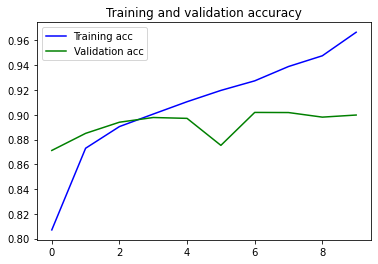

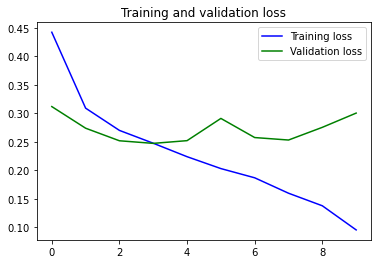

In [98]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

The training accuracy increased for the first few epochs and suddenly dropped and increase again, we can see that the validation accuracy does not increase exponentially like the training accuracy.
The same goes for training and validation loss. 

# 8. Sentiment Prediction using Skipgram

To predict sentiment using BiLSTM, we must first tokenize the sentence and pad it, then only fit it into BiLSTM model. Sentiment will be predicted based on the sentiment score. If score less than 0.3, it will be negative, if between 0.3 and 0.7 it will be neutral, if larger than 0.7 it will be positive.

In [100]:
def sg_predict(text, include_neutral=True):
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = sg_model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score)}

In [101]:
sg_predict("I think this is a very great movie.")

C:\Users\jingy\AppData\Local\Temp/ipykernel_1448/1161347097.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return {"label": label, "score": float(score)}


{'label': 'positive', 'score': 0.9327481389045715}

In [102]:
sg_predict("The movie is so bad, the actors are even worse.")

C:\Users\jingy\AppData\Local\Temp/ipykernel_1448/1161347097.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return {"label": label, "score": float(score)}


{'label': 'negative', 'score': 0.017284095287322998}

BiLSTM Model trained using Skipgram is able to successfully predict the sentiment of the two reviews.

# Summary
BiLSTM is a type recurrent neural network, benefit of BiLSTM is that it is able to capture long-term dependencies, solves vanishing gradient problem, suitable for sequential data, thus it is a good choice for sentiment analysis of long reviews.
Both BiLSTM achieved high accuracy, 0.8897 for CBOW and 0.8998 for Skipgram. Both models can be said to be a success as it has high training and validation accuracy.